# 1. Data overview and basic analysis

In [11]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing  import LabelEncoder

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

from scipy.stats import normaltest

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor


import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

pd.options.mode.chained_assignment = None

from tqdm import tqdm
tqdm.pandas()

import plotly.io as pio
from IPython.core.display import display, HTML 

In [12]:
# Setting the static image format
png_renderer = pio.renderers['png']
png_renderer.width = 1200
png_renderer.height = 700
png_renderer.engine = 'kaleido'
pio.renderers.default = 'png'  

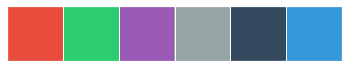

In [13]:
# Setting the color scheme
sns.set_theme(style = "darkgrid")
clrmap = ["#e74c3c","#2ecc71","#9b59b6", "#95a5a6", "#34495e","#3498db"]
sns.set_palette(clrmap)
sns.palplot(sns.color_palette())

In [14]:
df = pd.read_csv('data.csv')
df.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [16]:
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print ('% of gaps:')
display(cols_with_null)

% of gaps:


private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

In [17]:
for feature in df.columns:
    print(f'Number of {feature} feature unique values: {df[feature].nunique()}')

Number of status feature unique values: 159
Number of private pool feature unique values: 1
Number of propertyType feature unique values: 1280
Number of street feature unique values: 337076
Number of baths feature unique values: 229
Number of homeFacts feature unique values: 321009
Number of fireplace feature unique values: 1653
Number of city feature unique values: 2026
Number of schools feature unique values: 297365
Number of sqft feature unique values: 25405
Number of zipcode feature unique values: 4549
Number of beds feature unique values: 1184
Number of state feature unique values: 39
Number of stories feature unique values: 348
Number of mls-id feature unique values: 24907
Number of PrivatePool feature unique values: 2
Number of MlsId feature unique values: 232944
Number of target feature unique values: 43939


In [18]:
data = df.copy()

# 2. Feature engineering

### Private pool

In [19]:
print('private pool unique values: ', df['private pool'].unique())
print('PrivatePool unique values: ', df['PrivatePool'].unique())

private pool unique values:  [nan 'Yes']
PrivatePool unique values:  [nan 'yes' 'Yes']


Let's combine these features

In [20]:
data ['Private_pool'] = 0
for i in range (0, len(data)):
    if df['private pool'].iloc[i] == 'Yes' or df['PrivatePool'].iloc[i] in ['yes', 'Yes']:
        data ['Private_pool'].iloc[i] = 1

In [21]:
data = data.drop (['private pool','PrivatePool'], axis = 1)

### Status

Let's look at values

In [22]:
print('Number of unique values: ', df['status'].nunique())

Number of unique values:  159


In [23]:
list(df['status'].value_counts().nlargest(20).index)

['for sale',
 'Active',
 'For sale',
 'foreclosure',
 'New construction',
 'Pending',
 'Pre-foreclosure',
 'Pre-foreclosure / auction',
 'P',
 'Under Contract Show',
 ' / auction',
 'Under Contract   Showing',
 'Active Under Contract',
 'New',
 'Under Contract',
 'Contingent',
 'Price Change',
 'Auction',
 'Foreclosed',
 'A Active']

We'll convert the text to lowercase, and leave the first 5 characters to reduce the number of unique values

In [24]:
data['status'] = df['status'].progress_apply(lambda x: np.nan if x is np.nan else x.lower()[:5])

100%|██████████| 377185/377185 [00:00<00:00, 1121404.01it/s]


In [25]:
print('Number of unique values after converation: ', data['status'].nunique())

Number of unique values after converation:  44


We'll take into account 15 largest values

In [26]:
print('Share (%) of the 15 largest values: ' , round((data['status'].value_counts().nlargest(15)/len(data)*100).sum(),1))

Share (%) of the 15 largest values:  89.1


In [27]:
status_list = list(data['status'].value_counts().nlargest(15).index)
data['status'] = data['status'].progress_apply(lambda x: x if x in status_list else 'other')

100%|██████████| 377185/377185 [00:00<00:00, 1321393.03it/s]


### propertyType

Will do the same.

In [28]:
print('Number unique values: ', df['propertyType'].nunique())

Number unique values:  1280


In [29]:
data['propertyType'] = df['propertyType'].progress_apply(lambda x: np.nan if x is np.nan else x.lower()[:5])

100%|██████████| 377185/377185 [00:00<00:00, 1042819.12it/s]


In [30]:
print('Number of unique values after converation: ', data['propertyType'].nunique())

Number of unique values after converation:  167


In [31]:
print('Share (%) of the 15 largest values: ' , round((data['propertyType'].value_counts().nlargest(15)/len(data)*100).sum(),1))

Share (%) of the 15 largest values:  87.4


In [32]:
property_type_list = list(data['propertyType'].value_counts().nlargest(15).index)
data['propertyType'] = data['propertyType'].progress_apply(lambda x: x if x in property_type_list else 'other')

100%|██████████| 377185/377185 [00:00<00:00, 1272433.93it/s]


### baths

Let's look at the feature format

In [33]:
df['baths'].unique()[:10]

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths'], dtype=object)

We'll clean values from extra symbols

In [34]:
def get_number(x):
    x = str(x)
    if '/' in x:
        s = x.split('/')
        if '0' in s[0]:
            b = 0
        else:
            b = len(s)
    else: 
        a = re.findall(r"[-+]?(?:\d*\.*\d+)", x.replace(',', '.'))
        if re.findall("\d+", x) != []:
            b = float(a[0])
            return b
        else:
            return np.nan

In [35]:
data['baths'] = df['baths'].progress_apply(get_number)

100%|██████████| 377185/377185 [00:01<00:00, 312221.57it/s]


### homeFacts

Let's look at the feature format

In [36]:
df['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

We'll break this string into separate dicts using function literal_eval() from ast module

In [37]:
facts = ast.literal_eval(df['homeFacts'][0])['atAGlanceFacts']
for fact in facts:
    print (fact)
print (facts)

{'factValue': '2019', 'factLabel': 'Year built'}
{'factValue': '', 'factLabel': 'Remodeled year'}
{'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}
{'factValue': '', 'factLabel': 'Cooling'}
{'factValue': '', 'factLabel': 'Parking'}
{'factValue': None, 'factLabel': 'lotsize'}
{'factValue': '$144', 'factLabel': 'Price/sqft'}
[{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]


Let's create 7 new features

In [38]:
feature_list = ['Cooling','lotsize','Parking','Heating', 'Year built','Remodeled year','Price/sqft']

In [39]:
for f in feature_list:
    data[f] = np.nan

In [40]:
for i in range (0, len(data)):
    facts = ast.literal_eval(df['homeFacts'][i])['atAGlanceFacts']
    for fact in facts:
        data[fact['factLabel']].iloc[i] = fact['factValue']

Now we need to convert these features

Cooling

In [41]:
data['Cooling'].unique()[:10]

array(['', 'Central', 'Central Air', 'Central Gas', 'Steam Heating',
       'Central, Evaporative', 'Has Cooling',
       'Air Conditioning Unit(s), Ceiling Fan(s)', 'Central A/C',
       'No Data'], dtype=object)

In [42]:
print('Number of unique values: ', data['Cooling'].nunique())

Number of unique values:  1445


In [43]:
data['Cooling'] = data['Cooling'].progress_apply(lambda x: np.nan if x is None else x.lower()[:5])

100%|██████████| 377185/377185 [00:00<00:00, 1037416.18it/s]


In [44]:
print('Number of unique values after converation: ', data['Cooling'].nunique())

Number of unique values after converation:  122


In [45]:
print('Share (%) of the 10 largest values: ' , round((data['Cooling'].value_counts().nlargest(10)/len(data)*100).sum(),1))

Share (%) of the 10 largest values:  96.1


In [46]:
Cooling_list = list(data['Cooling'].value_counts().nlargest(10).index)
data['Cooling'] = data['Cooling'].progress_apply(lambda x: x if x in Cooling_list else 'other')

100%|██████████| 377185/377185 [00:00<00:00, 1272889.52it/s]


lotsize

Let's make a function to extract a number from this feature, taking into account different units of measurement

In [47]:
def square(x):
    if type(x) == str:
        a = re.findall(r"[-+]?(?:\d*\.*\d+)", x.replace(',', ''))
        if re.findall("\d+", x) != []:
            b = float(a[0])
            if 'cres' in x:
                b = b*43560.04
            return b
        else:
            return np.nan
    else:
        return np.nan

In [48]:
data['lotsize'] = data['lotsize'].progress_apply(square) 

100%|██████████| 377185/377185 [00:01<00:00, 311720.00it/s]


Parking

In [49]:
data['Parking'].unique()[:10]

array(['', 'Attached Garage', 'Detached Garage',
       'Carport, Attached Garage', '2 spaces', '4 spaces', 'Off Street',
       'None', '0', '1 space'], dtype=object)

In [50]:
print('Number of unique values: ', data['Parking'].nunique())

Number of unique values:  3346


In [51]:
data['Parking'] = data['Parking'].progress_apply(lambda x: np.nan if x is None else x.lower()[:5])

100%|██████████| 377185/377185 [00:00<00:00, 1216175.11it/s]


In [52]:
print('Number of unique values after converation: ', data['Parking'].nunique())

Number of unique values after converation:  342


In [53]:
print('Share (%) of the 10 largest values: ' , round((data['Parking'].value_counts().nlargest(10)/len(data)*100).sum(),1))

Share (%) of the 10 largest values:  91.7


In [54]:
Parking_list = list(data['Parking'].value_counts().nlargest(10).index)
data['Parking'] = data['Parking'].progress_apply(lambda x: x if x in Parking_list else 'other')

100%|██████████| 377185/377185 [00:00<00:00, 1285526.91it/s]


Heating

In [55]:
data['Heating'].unique()[:10]

array(['Central A/C, Heat Pump', '', 'Forced Air', 'Electric, Heat Pump',
       'Gas', 'Central Electric', 'Forced air', 'Other',
       'Forced air, Heat pump', 'Central Air'], dtype=object)

In [56]:
print('Number of unique values: ', data['Heating'].nunique())

Number of unique values:  1984


In [57]:
data['Heating'] = data['Heating'].progress_apply(lambda x: np.nan if x is None else x.lower()[:5])

100%|██████████| 377185/377185 [00:00<00:00, 1112138.01it/s]


In [58]:
print('Number of unique values after converation: ', data['Heating'].nunique())

Number of unique values after converation:  237


In [59]:
print('Share (%) of the 10 largest values: ' , round((data['Heating'].value_counts().nlargest(10)/len(data)*100).sum(),1))

Share (%) of the 10 largest values:  95.4


In [60]:
Heating_list = list(data['Heating'].value_counts().nlargest(10).index)
data['Heating'] = data['Heating'].progress_apply(lambda x: x if x in Heating_list else 'other')

100%|██████████| 377185/377185 [00:00<00:00, 1276627.37it/s]


Year built

We'll make a modified universal function for extracting numbers, including float, for several features

In [61]:
def get_float(string):
    a = re.findall(r"[-+]?(?:\d*\.*\d+)", str(string).replace(',', '.'))
    if a != []:
        b = float(a[0])
        return b
    else:
        return np.nan

In [62]:
data['Year built'] = data['Year built'].progress_apply(get_float)

100%|██████████| 377185/377185 [00:00<00:00, 465353.02it/s]


Let's change the year of construction to the age of the house

In [63]:
data['Year built'] = data['Year built'].progress_apply(lambda x: 2022 - x)

100%|██████████| 377185/377185 [00:00<00:00, 1186619.61it/s]


Remodeled year

Will do the same

In [64]:
data['Remodeled year'] = data['Remodeled year'].progress_apply(get_float)
data['Remodeled year'] = data['Remodeled year'].progress_apply(lambda x: 2022 - x)

100%|██████████| 377185/377185 [00:00<00:00, 1192302.89it/s]


Price/sqft

In [65]:
data['Price/sqft'] = data['Price/sqft'].progress_apply(get_float)

100%|██████████| 377185/377185 [00:00<00:00, 411792.40it/s]


In [66]:
data = data.drop('homeFacts', axis = 1)

### city

In [67]:
data['city'].unique()[:10]

array(['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas',
       'Palm Bay', 'Philadelphia', 'POINCIANA', 'Memphis', 'Mason City',
       'Houston'], dtype=object)

In [68]:
print('Number of unique values: ', data['city'].nunique())

Number of unique values:  2026


In [69]:
data['city'] = df['city'].progress_apply(lambda x: np.nan if x is np.nan else x.lower())

100%|██████████| 377185/377185 [00:00<00:00, 1353446.35it/s]


In [70]:
print('Number of unique values after convertation: ', data['city'].nunique())

Number of unique values after convertation:  1909


In [71]:
print('Share (%) of the 400 largest values: ' , round((df['city'].value_counts().nlargest(400)/len(data)*100).sum(),1))

Share (%) of the 400 largest values:  92.5


In [72]:
city_list = list(df['city'].value_counts().nlargest(400).index)
data['city'] = df['city'].progress_apply(lambda x: x if x in city_list else 'other')

100%|██████████| 377185/377185 [00:00<00:00, 625878.69it/s]


### schools

Let's look at the feature format

In [73]:
df['schools'][0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

We'll break this string into separate dicts using function literal_eval() from ast module

In [74]:
facts = ast.literal_eval(df['schools'][0])
for fact in facts:
    print (fact)
print (facts)

{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}
[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]


We'll create a function for extracting features, taking into account the format: the number of schools, and the minimum, average and maximum rating of schools and distance to school

In [75]:
 def schools_feature (x):
    
    x =  ast.literal_eval(x)
    schools = pd.json_normalize(x)
            
    len_list = []
    for i in range(0,4):
        len_list.append(len(schools.iloc[0][i]))
    mx = max(len_list)
    
    for col in list(schools.columns):
        while len(schools[col][0]) < mx:
            schools[col].iloc[0].append(np.nan)
            
    schools = schools.explode(['rating','name','data.Distance', 'data.Grades'])
       

    if len(schools['rating']) == 1 and schools['rating'][0] is np.nan:
        Min_rating, Max_rating, Mean_rating = np.nan, np.nan, np.nan
    else: 
        schools['rating'] = schools['rating'].apply(get_float)
        Min_rating, Max_rating, Mean_rating = schools['rating'].min(), schools['rating'].max(), schools['rating'].mean()

        
    if len(schools['data.Distance']) == 1 and schools['data.Distance'][0] is np.nan:
        Min_distance, Max_distance, Mean_distance = np.nan, np.nan, np.nan
    else: 
        schools['data.Distance'] = schools['data.Distance'].apply(get_float)
        Min_distance, Max_distance, Mean_distance = schools['data.Distance'].min(), schools['data.Distance'].max(), schools['data.Distance'].mean()

    return len(schools), Min_rating, Max_rating, Mean_rating, Min_distance, Max_distance, Mean_distance

    
school_feature_list = ['Number of schools', 'Min rating', 'Max rating', 'Mean rating', 'Min distance', 'Max distance', 'Mean distance']
  
data [['Number of schools', 'Min rating','Max rating','Mean rating','Min distance','Max distance','Mean distance']] = df['schools'].progress_apply(schools_feature).apply(pd.Series)

100%|██████████| 377185/377185 [27:48<00:00, 226.09it/s]


In [76]:
data = data.drop('schools', axis =1)
data.to_csv('prom_result.csv')

In [77]:
#data = pd.read_csv('prom_result.csv')
#data = data.drop('Unnamed: 0', axis = 1)
#data.head(1)

### sqft

In [78]:
data['sqft'] = df['sqft'].progress_apply(get_float)

100%|██████████| 377185/377185 [00:00<00:00, 408312.96it/s]


### zipcode

In [79]:
#print('Share (%) of the 2000 largest values: ' , round((df['zipcode'].value_counts().nlargest(2000)/len(data)*100).sum(),1))
#zipcode_list = list(df['zipcode'].value_counts().nlargest(2000).index)
#data['zipcode'] = df['zipcode'].progress_apply(lambda x: x if x in zipcode_list else 'other')

### beds

In [80]:
data['beds'] = df['beds'].progress_apply(get_float)
data['beds'] = data['beds'].progress_apply(lambda x: x if  (1<= x <1000 and x.is_integer()) else np.nan)

100%|██████████| 377185/377185 [00:00<00:00, 1236162.62it/s]


### state

In [81]:
print('Share (%) of the 15 largest values: ' , round((data['state'].value_counts().nlargest(15)/len(data)*100).sum(),1))
state_list = list(data['state'].value_counts().nlargest(15).index)
data['state'] = data['state'].progress_apply(lambda x: x if x in state_list else 'other')

Share (%) of the 15 largest values:  95.3


100%|██████████| 377185/377185 [00:00<00:00, 1412001.04it/s]


### stories

In [82]:
data['stories'] = df['stories'].progress_apply(get_float)
data['stories'] = data['stories'].progress_apply(lambda x: x if  (1<= x <100 and x.is_integer()) else np.nan)

100%|██████████| 377185/377185 [00:00<00:00, 1231165.96it/s]


### target

In [83]:
data['target'] = df['target'].progress_apply(get_float)

100%|██████████| 377185/377185 [00:00<00:00, 442352.12it/s]


# 3. Data cleaning

In [84]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null[cols_with_null>10])

mls-id            93.387330
fireplace         72.661956
Remodeled year    59.946711
stories           46.615852
beds              29.975476
baths             28.608508
lotsize           25.413259
MlsId             17.731352
Price/sqft        17.481342
Year built        16.860692
sqft              10.975251
dtype: float64

We'll remove features with a large number of gaps and uninformative features

In [85]:
data_drop = data.drop(['mls-id', 'MlsId','street', 'stories', 'Remodeled year', 'fireplace'], axis = 1)
data_drop.head(5)

,status,propertyType,baths,city,sqft,zipcode,beds,state,target,Private_pool,...,Heating,Year built,Price/sqft,Number of schools,Min rating,Max rating,Mean rating,Min distance,Max distance,Mean distance
0,activ,singl,3.5,Southern Pines,2900.000,28387,4.0,NC,418.000,0,...,centr,3.0,144.0,8.0,4.0,7.0,5.200000,2.70,12.60,5.537500
1,for s,singl,3.0,Spokane Valley,1.947,99216,3.0,WA,310.000,0,...,,3.0,159.0,3.0,4.0,10.0,6.000000,1.01,1.65,1.326667
2,for s,singl,2.0,Los Angeles,3.000,90049,3.0,CA,2.895,1,...,force,61.0,965.0,3.0,4.0,8.0,6.666667,1.19,2.63,1.960000
3,for s,singl,8.0,Dallas,6.457,75205,5.0,TX,2.395,0,...,force,16.0,371.0,4.0,9.0,10.0,9.250000,0.10,1.05,0.752500
4,for s,lot/l,NaN,Palm Bay,NaN,32908,NaN,FL,5.000,0,...,,NaN,NaN,3.0,4.0,5.0,4.666667,3.03,5.96,4.080000


In [86]:
data_drop = data_drop[data_drop['target'].notna()]

In [87]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             374704 non-null  object 
 1   propertyType       374704 non-null  object 
 2   baths              267777 non-null  float64
 3   city               374704 non-null  object 
 4   sqft               333771 non-null  float64
 5   zipcode            374704 non-null  object 
 6   beds               262379 non-null  float64
 7   state              374704 non-null  object 
 8   target             374704 non-null  float64
 9   Private_pool       374704 non-null  int64  
 10  Cooling            374704 non-null  object 
 11  lotsize            279342 non-null  float64
 12  Parking            374704 non-null  object 
 13  Heating            374704 non-null  object 
 14  Year built         311437 non-null  float64
 15  Price/sqft         310896 non-null  float64
 16  Nu

Will fill gapes in dataset

In [88]:
fill_data = data_drop.copy()
values = {
    'beds': int(fill_data['beds'].median()),
    'baths': int(fill_data['baths'].median()),
    'lotsize': fill_data['lotsize'].median(),
    'Price/sqft': fill_data['Price/sqft'].median(),
    'Year built': fill_data['Year built'].median(),
    'sqft': fill_data['sqft'].median(),
    'Min rating': fill_data['Min rating'].median(),
    'Max rating': fill_data['Max rating'].median(),
    'Mean rating': fill_data['Mean rating'].median(),
    'Min distance': fill_data['Min distance'].median(),
    'Max distance': fill_data['Max distance'].median(),
    'Mean distance': fill_data['Mean distance'].median(),
    'Cooling': fill_data['Cooling'].mode()[0],
    'lotsize': fill_data['lotsize'].mode()[0],
    'Parking': fill_data['Parking'].mode()[0],
    'Heating': fill_data['Heating'].mode()[0],
    
}

fill_data = fill_data.fillna(values)

fill_data.isnull().mean()

status               0.0
propertyType         0.0
baths                0.0
city                 0.0
sqft                 0.0
zipcode              0.0
beds                 0.0
state                0.0
target               0.0
Private_pool         0.0
Cooling              0.0
lotsize              0.0
Parking              0.0
Heating              0.0
Year built           0.0
Price/sqft           0.0
Number of schools    0.0
Min rating           0.0
Max rating           0.0
Mean rating          0.0
Min distance         0.0
Max distance         0.0
Mean distance        0.0
dtype: float64

List of numeric variables

In [89]:
num_list = ['baths', 
            'sqft', 
            'beds', 
            'target', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Mean rating',
            'Min distance',
            'Max distance',
            'Mean distance'
           ]

Let's look at the distribution of numerical features

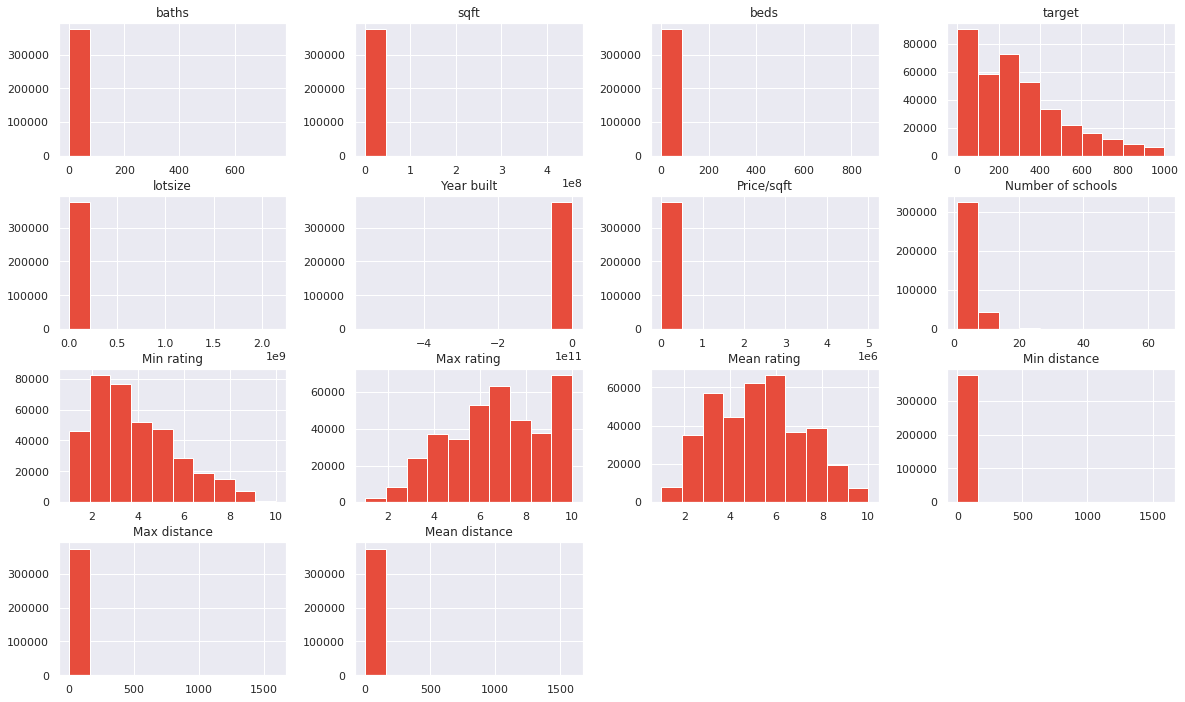

In [90]:
fill_data[num_list].hist(figsize=(20, 12))
pass

Some distributions look like lognormal, let's take this into account

Identifying and removing duplicates

In [91]:
mask = fill_data.duplicated(subset = fill_data.columns)
data_duplicates = fill_data[mask]
print(f'Number of duplicates found and deleted: {data_duplicates.shape[0]}')

fill_data = fill_data.drop_duplicates(subset = fill_data.columns)

Number of duplicates found and deleted: 2649


We'll clean up emissions in several stages:
1. Using the three sigma method
2. By the Tukey method

In [92]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return cleaned

In [93]:
num_list_to_clean = ['baths', 
            'sqft', 
            'beds', 
            'target', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Mean rating',
            'Min distance',
            'Max distance',
            'Mean distance'
           ]

first_cleaned_data = fill_data.copy()
for feature in num_list_to_clean:
    first_cleaned_data = outliers_z_score_mod(first_cleaned_data, feature, False, 3, 5)
    print(first_cleaned_data.shape)

(371818, 23)
(371817, 23)
(371626, 23)
(371626, 23)
(371573, 23)
(371571, 23)
(371563, 23)
(370037, 23)
(370037, 23)
(370037, 23)
(370037, 23)
(369823, 23)
(369690, 23)
(368990, 23)


In [94]:
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    #outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return  cleaned

In [95]:
num_list_to_clean = ['baths', 
            #'sqft', 
            'beds', 
            'target', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Mean rating',
            'Min distance',
            'Max distance',
            'Mean distance'
           ]
cleaned_data = first_cleaned_data.copy()
for feature in num_list_to_clean:
    cleaned_data = outliers_iqr_mod(cleaned_data, feature, True, 5, 5)
    print(cleaned_data.shape)

/home/igor/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/home/igor/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



(365182, 23)
(365112, 23)
(365112, 23)
(354765, 23)
(354755, 23)
(346464, 23)
(342619, 23)
(342619, 23)
(342619, 23)
(342619, 23)
(341739, 23)
(341739, 23)
(341739, 23)


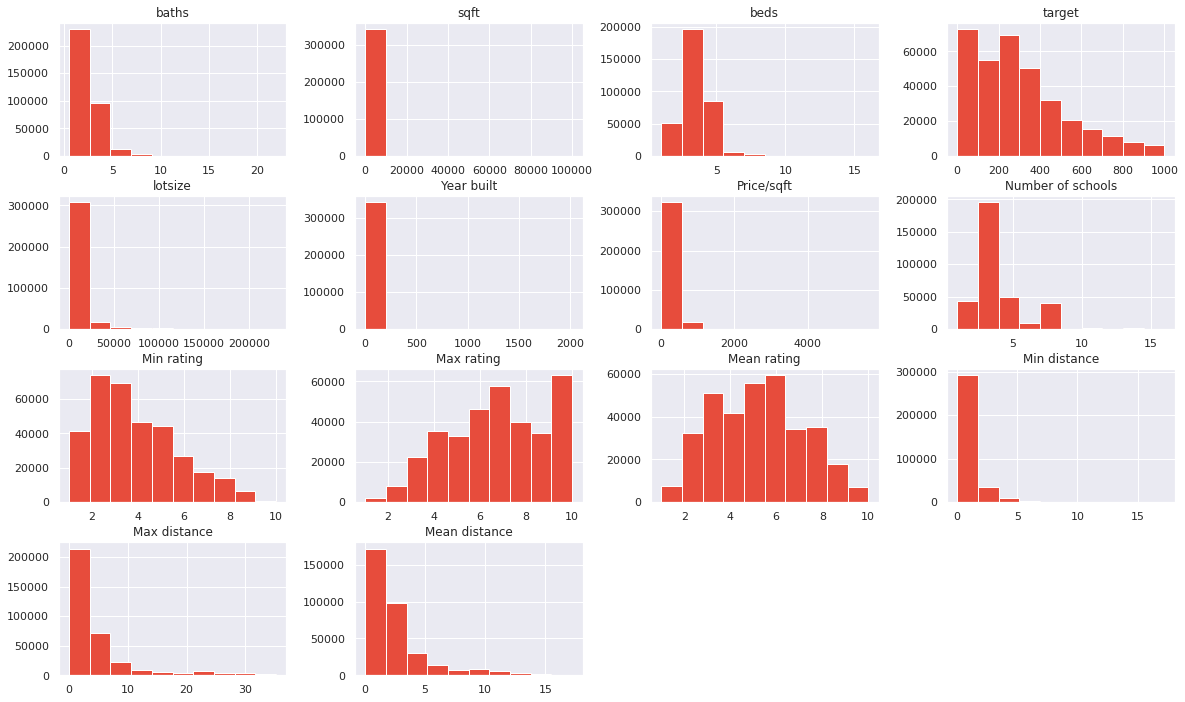

In [96]:
num_list = ['baths', 
            'sqft', 
            'beds', 
            'target', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Mean rating',
            'Min distance',
            'Max distance',
            'Mean distance'
           ]
cleaned_data[num_list].hist(figsize=(20, 12))
pass

In [97]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341739 entries, 0 to 377184
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             341739 non-null  object 
 1   propertyType       341739 non-null  object 
 2   baths              341739 non-null  float64
 3   city               341739 non-null  object 
 4   sqft               341739 non-null  float64
 5   zipcode            341739 non-null  object 
 6   beds               341739 non-null  float64
 7   state              341739 non-null  object 
 8   target             341739 non-null  float64
 9   Private_pool       341739 non-null  int64  
 10  Cooling            341739 non-null  object 
 11  lotsize            341739 non-null  float64
 12  Parking            341739 non-null  object 
 13  Heating            341739 non-null  object 
 14  Year built         341739 non-null  float64
 15  Price/sqft         341739 non-null  float64
 16  Nu

Let's look at the feature correlation

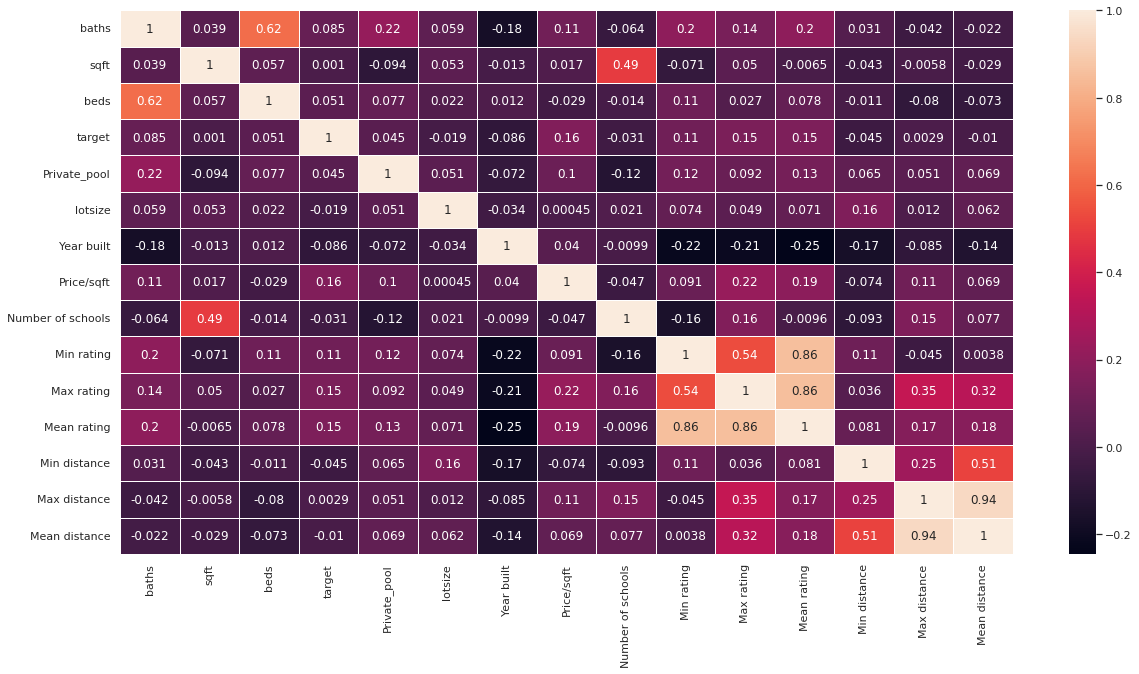

In [98]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cleaned_data.corr(), annot=True, linewidths=.5, ax=ax)
pass

And remove correlated features

In [99]:
cleaned_data = cleaned_data.drop(['Max distance', 'Mean rating'], axis = 1)

# 4. Exploration Data Analysis (EDA)

Let's look at the distribution of cost squared by state

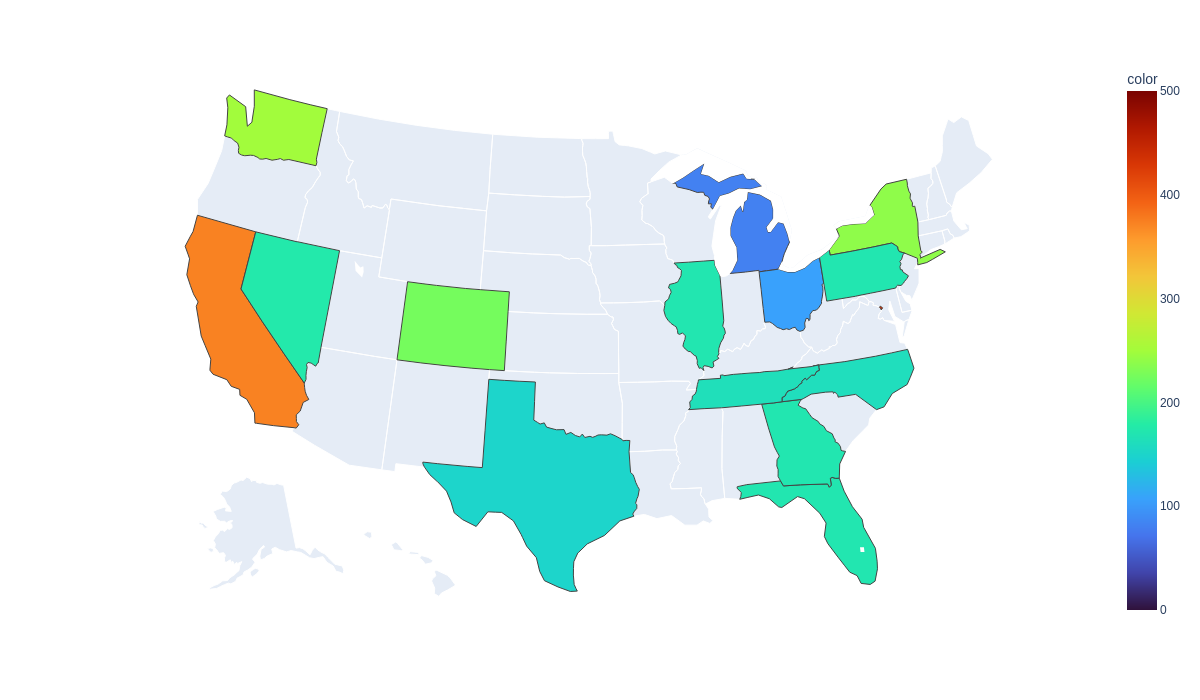

In [100]:
pic_1 = cleaned_data.groupby('state')['Price/sqft'].median().to_frame().reset_index()

fig_1 = px.choropleth(
    data_frame = pic_1, 
    locations = 'state', 
    locationmode="USA-states", 
    color = pic_1['Price/sqft'].values,
    range_color = [0, 500], 
    scope='usa',
    width = 800, 
    height = 500, 
    color_continuous_scale = 'Turbo'
    );

pio.write_html(fig_1, file = 'plotly//state-cost squared distribution.html', auto_open = False)

display(HTML("""<a href="https://htmlpreview.github.io/?https://github.com/IgorAbalakin/Real_Estate_Agency/blob/main/plotly/state-cost%20squared%20distribution.html">Interactive visualization Plotly"""))

fig_1.show()

The more developed states, on the west and east coasts, are expected to be more expensive

Let's look at the impact of having own pool

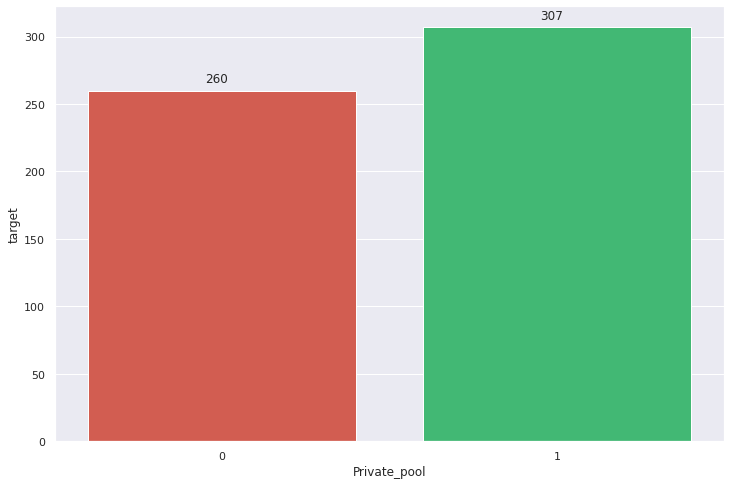

In [101]:
pic_2 = cleaned_data.groupby('Private_pool')['target'].median().to_frame().reset_index()

fig = plt.figure(figsize=(12, 8))

barplot = sns.barplot(
    data = pic_2,
    x = 'Private_pool',
    y = 'target',
    );
for p in barplot.patches:
        barplot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+6))

Due to the large number of gaps the difference turned out to be insignificant. Perhaps it is better to remove this feature from consideration

Let's see how the distance to school affects

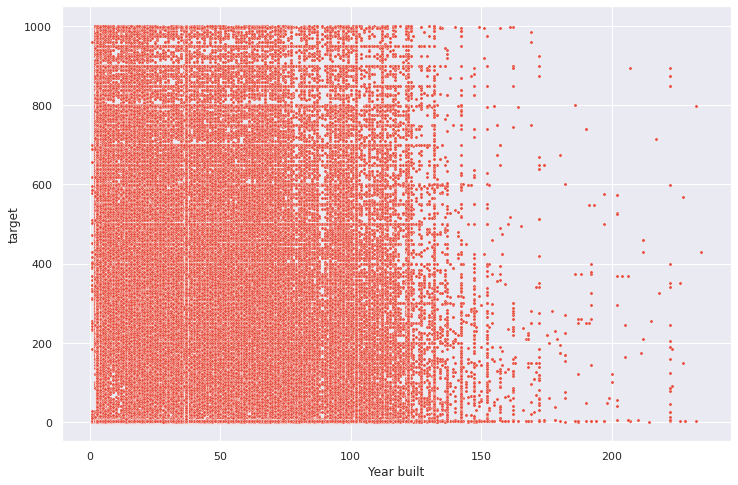

In [102]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x= cleaned_data[cleaned_data['Year built']<250]['Year built'], y=cleaned_data['target'], ax=ax, s = 10)
ax.set_xlabel('Year built')
ax.set_ylabel('target');

Objects located near far from schools are cheaper

/home/igor/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



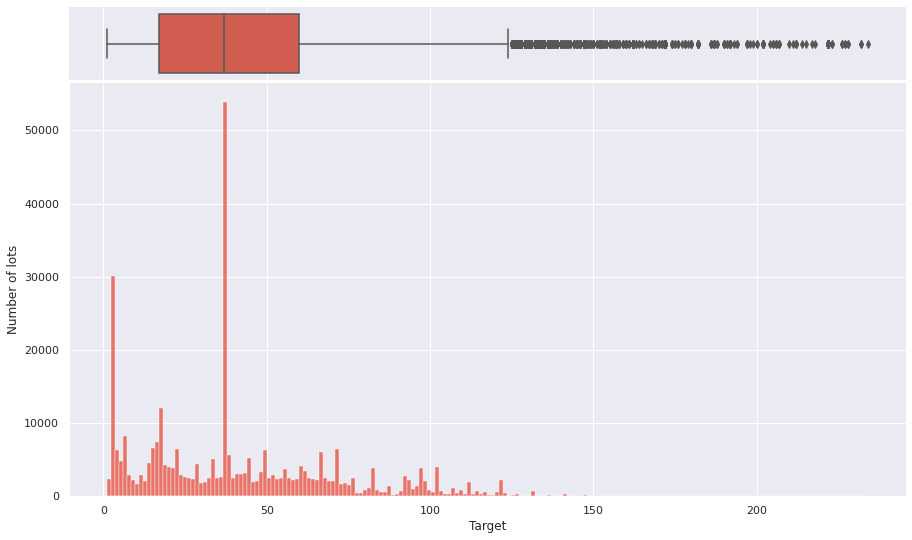

In [103]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize = (15, 9),
                                    gridspec_kw={"height_ratios": (.15, .85)})

plt.subplots_adjust(hspace = 0.01)

sns.boxplot(cleaned_data[cleaned_data['Year built']<250]['Year built'], ax=ax_box)
sns.histplot(cleaned_data[cleaned_data['Year built']<250]['Year built'], ax=ax_hist)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
#ax_box.set_title('Distribution of the trip duration on a logarithmic scale', fontsize = 16);
ax_hist.set_xlabel('Target');
ax_hist.set_ylabel('Number of lots');

There are two peaks of construction: new buildings, and the main building years (about 40 years ago)

Let's look at the target feature

p=0.000
The data is NOT distributed normally


/home/igor/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



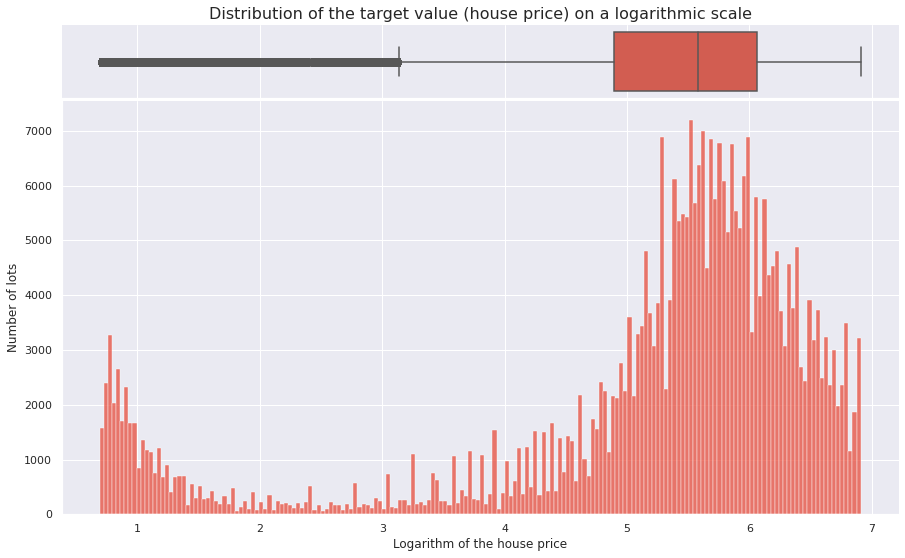

In [104]:
H0 = 'The data is distributed normally'
Ha = 'The data is NOT distributed normally'

target = cleaned_data['target'].apply(lambda x: np.log(x+1))

alpha = 0.05

_, p = normaltest(target)
print('p=%.3f' % p)

if p > alpha/2:
    print(H0)
else:
    print(Ha)

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize = (15, 9),
                                    gridspec_kw={"height_ratios": (.15, .85)})

plt.subplots_adjust(hspace = 0.01)

sns.boxplot(target, ax=ax_box)
sns.histplot(target, ax=ax_hist)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
ax_box.set_title('Distribution of the target value (house price) on a logarithmic scale', fontsize = 16);
ax_hist.set_xlabel('Logarithm of the house price');
ax_hist.set_ylabel('Number of lots');

# 5. Preparing data for training

Logarithm numeric features

In [105]:
num_list_to_log = ['baths', 
            'sqft', 
            'beds', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Min distance',
            'Mean distance'
           ]

for feature in num_list_to_log:
    cleaned_data[feature] = cleaned_data[feature].progress_apply(lambda x: np.log(x+1) if x >= 0 else 0)

100%|██████████| 341739/341739 [00:00<00:00, 592903.75it/s]


We'll encode categorical features using Label Encoder

In [113]:
cat_list = ['status', 
            'propertyType', 
            'city', 
            'zipcode', 
            'state', 
            'Cooling', 
            'Parking', 
            'Heating'
           ]
for feature in cat_list:
    cleaned_data[feature] = LabelEncoder().fit_transform(cleaned_data[feature])
    cleaned_data[feature] = cleaned_data[feature].astype("category")

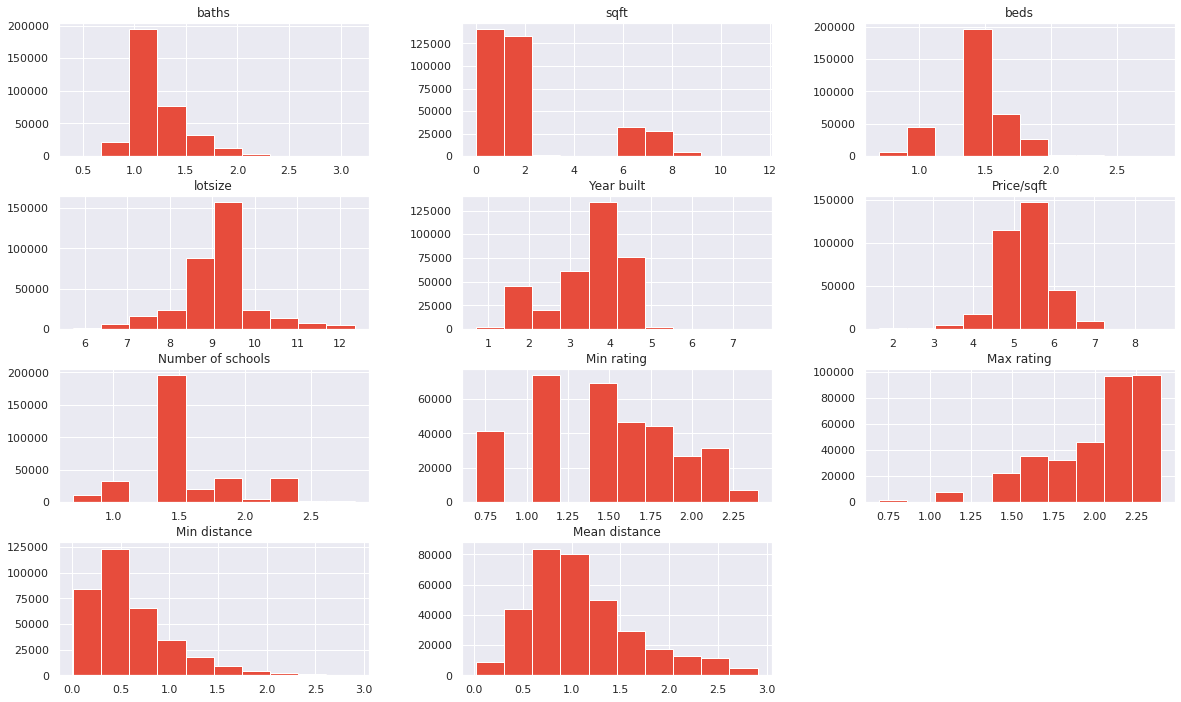

In [107]:
num_list = ['baths', 
            'sqft', 
            'beds', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Min distance',
            'Mean distance'
           ]
cleaned_data[num_list].hist(figsize=(20, 12))
pass

In [116]:
X = cleaned_data.drop('target', axis=1)
y = cleaned_data['target'].apply(lambda x: np.log(x+1))

Feature importance estimation

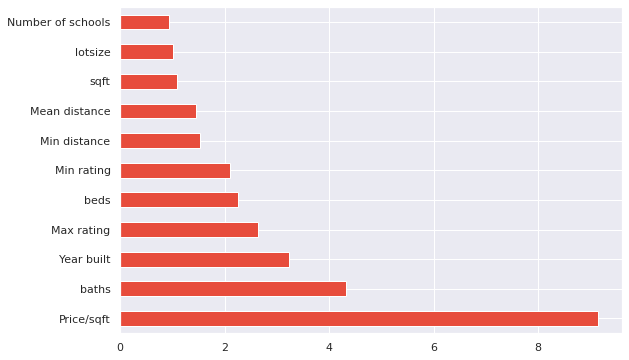

In [109]:
num_list_to_scale = ['baths', 
            'sqft', 
            'beds', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            #'Mean rating',
            'Min distance',
            #'Max distance',
            'Mean distance'
           ]
plt.rcParams['figure.figsize'] = (9,6)
imp_num = pd.Series(f_classif(X[num_list_to_scale], y)[0], index = num_list_to_scale)
imp_num.sort_values(inplace = True, ascending = False)
imp_num.plot(kind = 'barh')
pass

In [112]:
X[cat_list]

,status,propertyType,city,zipcode,state,Cooling,Parking,Heating
0,activ,singl,Southern Pines,28387,NC,,,centr
1,for s,singl,Spokane Valley,99216,WA,,,
2,for s,singl,Los Angeles,90049,CA,centr,attac,force
3,for s,singl,Dallas,75205,TX,centr,detac,force
4,for s,lot/l,Palm Bay,32908,FL,,,
...,...,...,...,...,...,...,...,...
377180,other,singl,Miami,33180,FL,centr,2 spa,other
377181,for s,condo,Chicago,60657,IL,,other,other
377182,for s,singl,Jamaica,11434,NY,,other,other
377183,other,other,Houston,77028,TX,other,other,other


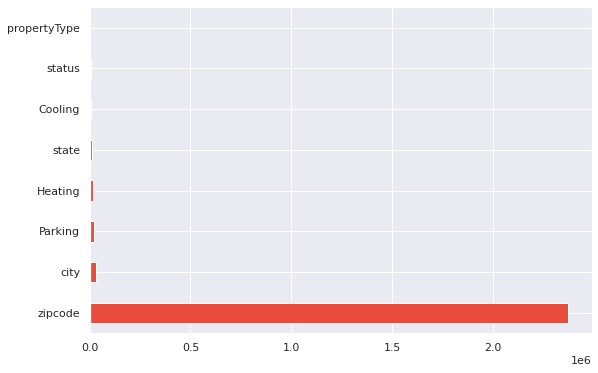

In [117]:
cat_list = ['status', 
            'propertyType', 
            #'fireplace', 
            'city', 
            'zipcode', 
            'state', 
            'Cooling', 
            'Parking', 
            'Heating'
           ]
plt.rcParams['figure.figsize'] = (9,6)
y_int = y.astype('int')
imp_cat = pd.Series(chi2(X[cat_list], y_int)[0], index=cat_list)
imp_cat.sort_values(inplace = True, ascending = False)
imp_cat.plot(kind = 'barh')
pass

Let's divide the sample into a training and a test

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

Let's standardize the data before passing it to the model

In [ ]:
num_list_to_scale = ['baths', 
            'sqft', 
            'beds', 
            'lotsize', 
            'Year built', 
            'Price/sqft', 
            'Number of schools', 
            'Min rating',
            'Max rating',
            'Min distance',
            'Mean distance'
           ]

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[num_list_to_scale])
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_list_to_scale]), columns=num_list_to_scale)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid[num_list_to_scale]), columns=num_list_to_scale)

In [ ]:
X_train_scaled = pd.concat([X_train_scaled, X_train[cat_list].reset_index(drop=True)], axis = 1)
X_valid_scaled = pd.concat([X_valid_scaled, X_valid[cat_list].reset_index(drop=True)], axis = 1)

# 6. Solving the regression problem: classical algorithms

**There are a lot of outliers in the data, so we will choose MAPE as a metric - how much % our model differs from the real object cost.**

*LinearRegression*

In [ ]:
lr= linear_model.LinearRegression()
#Training the model — we are looking for parameters according to the LSM
lr.fit(X_train_scaled,  y_train)
y_train_predict = lr.predict(X_train_scaled)
y_valid_predict = lr.predict(X_valid_scaled)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

*PolynomialFeatures*

In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=True)
poly.fit(X_train_scaled)
#Generating polynomial features for a training sample
X_train_poly = poly.transform(X_train_scaled)
#Generating polynomial features for a test sample
X_valid_poly = poly.transform(X_valid_scaled)

lr_model_poly = linear_model.LinearRegression()
#Training the model by the LSM
lr_model_poly.fit(X_train_poly, y_train)
#Making a prediction for a training sample
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Making a prediction for a test sample
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
                  
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict_poly)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict_poly)), '%')

*Ridge*

In [ ]:
ridge_lr_poly = linear_model.Ridge(alpha=1, solver = 'cholesky'
                                  # positive = True
                                  )
#Training the model
ridge_lr_poly.fit(X_train, y_train)
#Making a prediction for a training sample
y_train_predict = ridge_lr_poly.predict(X_train)
#Making a prediction for a test sample
y_valid_predict = ridge_lr_poly.predict(X_valid)

print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

*Lasso*

In [ ]:
clf = linear_model.Lasso(alpha=0.05)
clf.fit(X_train, y_train)
#Making a prediction for a training sample
y_train_predict = clf.predict(X_train)
#Making a prediction for a test sample
y_valid_predict = clf.predict(X_valid)

print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

*DecisionTreeRegressor*

In [ ]:
regr = DecisionTreeRegressor()
#Training the model — we are looking for parameters according to the LSM
regr.fit(X_train_scaled,  y_train)
y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

The first acceptable result

In [ ]:
max_depths = range(7, 30)
#Creating empty lists to which we will add the results
train_scores = []
valid_scores = []
for depth in max_depths:
    #Creating an object of the linear regression class with L1 regularization
    regr = DecisionTreeRegressor(max_depth = depth)
    #Training the model
    regr.fit(X_train,  y_train)
    #Making a prediction for a training sample
    y_train_predict = regr.predict(X_train)
    #Making a prediction for a test sample
    y_valid_predict = regr.predict(X_valid)
    #Calculating the determination coefficients for two samples and add them to the lists
    train_scores.append(metrics.mean_absolute_percentage_error(y_train,y_train_predict))
    valid_scores.append(metrics.mean_absolute_percentage_error(y_valid,y_valid_predict))
    
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(max_depths, train_scores, label='Train') 
ax.plot(max_depths, valid_scores, label='Valid') 
ax.set_xlabel('max_depths') 
ax.set_ylabel('MAPE') 
ax.set_xticks(max_depths) 
ax.xaxis.set_tick_params(rotation=45) 
ax.legend(); 

Let's perform the selection of hyperparameters with cross-validation

In [ ]:
space={
        'criterion': hp.choice ('criterion',['squared_error', 'friedman_mse', 'poisson']),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'max_depth' : hp.quniform('max_depth', 6, 30, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 20, 1)
      }

random_state =42
def hyperopt_dt(params, cv=5, X=X_train, y=y_train, random_state=random_state):

    params = {
            'criterion': params['criterion'],
            'min_samples_split': int(params['min_samples_split']), 
            'max_depth': int(params['max_depth']), 
            'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    model = DecisionTreeRegressor(**params, random_state=random_state)
 
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1).mean()

    return -score
 
trials = Trials()
best=fmin(hyperopt_dt, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=50, 
          trials=trials, 
          show_progressbar=True,
          rstate=np.random.RandomState(random_state)
         )

print("Best hyperparameter values {}".format(best))

In [ ]:
best=fmin(hyperopt_dt, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=50, 
          trials=trials, 
          rstate=np.random.RandomState(random_state)
         )
print("Best hyperparameter values {}".format(best))

In [ ]:
%%time
regr = DecisionTreeRegressor(max_depth = 30, min_samples_leaf = 2, min_samples_split = 2,  criterion = 'squared_error')

regr.fit(X_train,  y_train)
y_train_predict = regr.predict(X_train)
y_valid_predict = regr.predict(X_valid)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

# 7. Solving the regression problem: ensemble algorithms

*RandomForestRegressor*

In [ ]:
%%time
RFregr = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=42)
RFregr.fit(X_train,  y_train)
y_train_predict = RFregr.predict(X_train)
y_valid_predict = RFregr.predict(X_valid)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

*GradientBoostingRegressor*

In [ ]:
%%time
gb = GradientBoostingRegressor(
    max_depth=10, 
    learning_rate=0.5,
    n_estimators=300, 
    random_state=42 
)
gb.fit(X_train,  y_train)
y_train_predict = gb.predict(X_train)
y_valid_predict = gb.predict(X_valid)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

*StackingRegressor*

In [ ]:
%%time
estimators = [
    ('dt', DecisionTreeRegressor(max_depth = 28, min_samples_leaf = 2, min_samples_split = 4)),
    ('rf', RandomForestRegressor (max_depth=20, n_estimators=100, random_state=42))
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator = CatBoostRegressor(iterations=100,
                          l2_leaf_reg = 2.75,
                          learning_rate=0.75,
                          depth=10
                          #cat_features = cat_list
                         ),
    verbose = 2
)


model.fit(X_train_scaled,  y_train)
y_train_predict = model.predict(X_train_scaled)
y_valid_predict = model.predict(X_valid_scaled)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

# 8. Solving the regression problem: advanced algorithms

*CatBoostRegressor*

In [ ]:
%%time
cat_list = ['status', 
            'propertyType', 
            #'fireplace', 
            'city', 
            'zipcode', 
            'state', 
            'Cooling', 
            'Parking', 
            'Heating'
           ]

model = CatBoostRegressor(iterations=1000,
                          #l2_leaf_reg = 2.75,
                          learning_rate=0.55,
                          depth=10,
                          
                          cat_features = cat_list
                         )
model.fit(X_train_scaled,  y_train)
y_train_predict = model.predict(X_train_scaled)
y_valid_predict = model.predict(X_valid_scaled)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Selection of hyperparameters with cross-validation

In [ ]:
space={
        'iterations': hp.quniform ('iterations', 100, 500, 50),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'depth' : hp.quniform('depth', 2, 11, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.2,  3)
      }

random_state =42
def hyperopt_ct(params, cv=5, X=X_train, y=y_train, random_state=random_state):

    params = {
            'iterations': params['iterations'],
            'learning_rate': params['learning_rate'], 
            'depth': params['depth'], 
            'l2_leaf_reg': params['l2_leaf_reg']
              }
  
    model = CatBoostRegressor(**params, cat_features = cat_list, random_state=random_state)
 
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1).mean()

    return -score
 
trials = Trials()
best=fmin(hyperopt_ct, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          show_progressbar=True,
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )

print("Best hyperparameter values {}".format(best))

*XGBoost*

In [ ]:
dtrain = xgb.DMatrix(X_train_scaled, label = y_train, enable_categorical = True, feature_names=X_train_scaled.columns)

dvalid = xgb.DMatrix(X_valid_scaled, label = y_valid, enable_categorical = True, feature_names=X_train_scaled.columns)

# Hyperparameters of the model
xgb_pars = {'learning_rate' : 1,'min_child_weight': 10, 'eta': 0.8, 'colsample_bytree': 0.9, 
            'max_depth': 15,'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'mape', 'objective': 'reg:squarederror'
           }
# Training and validation sample
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Training XGBoost model
model = xgb.train(
     
    params=xgb_pars, 
    dtrain=dtrain, 
    num_boost_round=100,
    evals=watchlist, 
    early_stopping_rounds=10, 
    maximize=False, 
    verbose_eval=10 
)

y_train_predict = model.predict(dtrain)
y_valid_predict = model.predict(dvalid)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

*LGBMRegressor*

In [ ]:
%%time
model = LGBMRegressor(boosting_type='gbdt', 
                      learning_rate=0.05, 
                      n_estimators=500, 
                      colsample_bytree=0.9, 
                      random_state=42, 
                      n_jobs=- 1
                     )
model.fit(X_train_scaled,  y_train)
y_train_predict = model.predict(X_train_scaled)
y_valid_predict = model.predict(X_valid_scaled)
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

The best accuracy was achieved using stacking - 7.96%.